<a href="https://colab.research.google.com/github/Prakhar-Gupta-03/CV_Assignments/blob/main/A1/CV_A1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###WandB Setup

In [41]:
!pip install wandb onnx -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [42]:
import wandb
#WandB Login
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [43]:
model_config = dict(
    epochs=10,
    classes=10,
    kernels=[3, 3, 3],
    features=[32, 64, 128],
    batch_size=16,
    optimizer="Adam",
    learning_rate=0.001,
    dataset="Russian WildLife Dataset",
    architecture="ConvNet")

In [44]:
run_num = 1
wandb.init(
    project = "CV_A1_Q2",
    name = f"Experiment_{run_num}",
    config = model_config,
)

wandb: Currently logged in as: prakhar21550. Use `wandb login --relogin` to force relogin


###Importing libraries

In [19]:
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import utils
from torchvision.transforms import v2 as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Dataset download and setu

In [21]:
os.chdir('/content')

In [22]:
!pwd

/content


In [23]:
# mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!unzip "/content/drive/MyDrive/Cropped_final_downloaded_ver.zip" -d "/content/Data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/Cropped_final/people/0120_p_crop01_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0122_p_crop01_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0123_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0085_p_crop02_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0080_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0070_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0071_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0079_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0069_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0089_p_crop01_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0074_p_crop00_detections.jpg  
  inflating: /content/Data/Cropped_final/people/0057_p_crop01_detections.jpg  
 

In [25]:
os.chdir('/content/Data/Cropped_final')

In [26]:
!ls

amur_leopard  birds	  brown_bear  people	sika_deer
amur_tiger    black_bear  dog	      roe_deer	wild_boar


###Dataset Class

In [27]:
class RussianWildLifeDataset(Dataset):
  def __init__(self, root_dir, transform):
    self.transform = transform
    self.root_dir = root_dir
    self.classes = os.listdir(self.root_dir)
    self.classes.sort()
    self.class_index_mapping = dict(zip(range(len(self.classes)), self.classes))
    self.__load_data__()

  def __load_data__(self):
    self.images_filenames = []
    self.labels = []
    for i in range(len(self.class_index_mapping)):
      class_path = os.path.join(self.root_dir, self.class_index_mapping[i])
      for image in os.listdir(class_path):
        self.images_filenames.append(os.path.join(class_path, image))
        self.labels.append(i)

  def get_class_name(self, label):
    return self.class_index_mapping[label]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = im.open(self.images_filenames[idx])
    label = self.labels[idx]
    if (self.transform):
      image = self.transform(image)
    sample = {'image':image, 'label':label}
    return sample

###Transformations

In [28]:
composed_transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

###Dataset and DataLoaders

In [29]:
dataset = RussianWildLifeDataset("/content/Data/Cropped_final/", composed_transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.1, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

###Visualizing Training Data

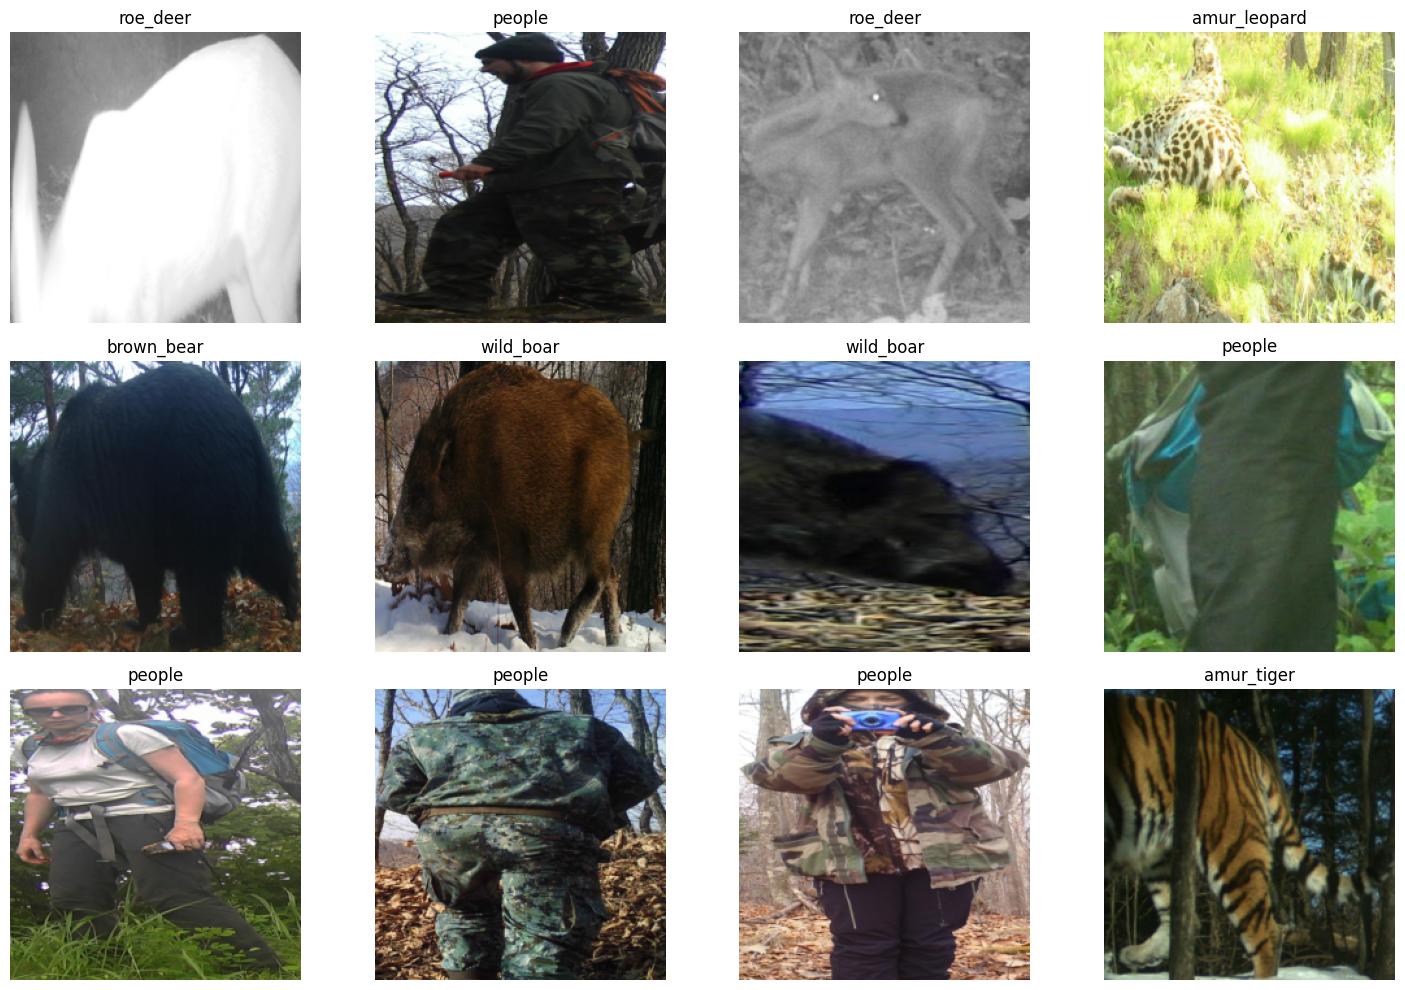

In [30]:
num_rows = 3
num_cols = 4
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(train_dataset):
            break
        sample = train_dataset[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

###Visualizing Validation Data


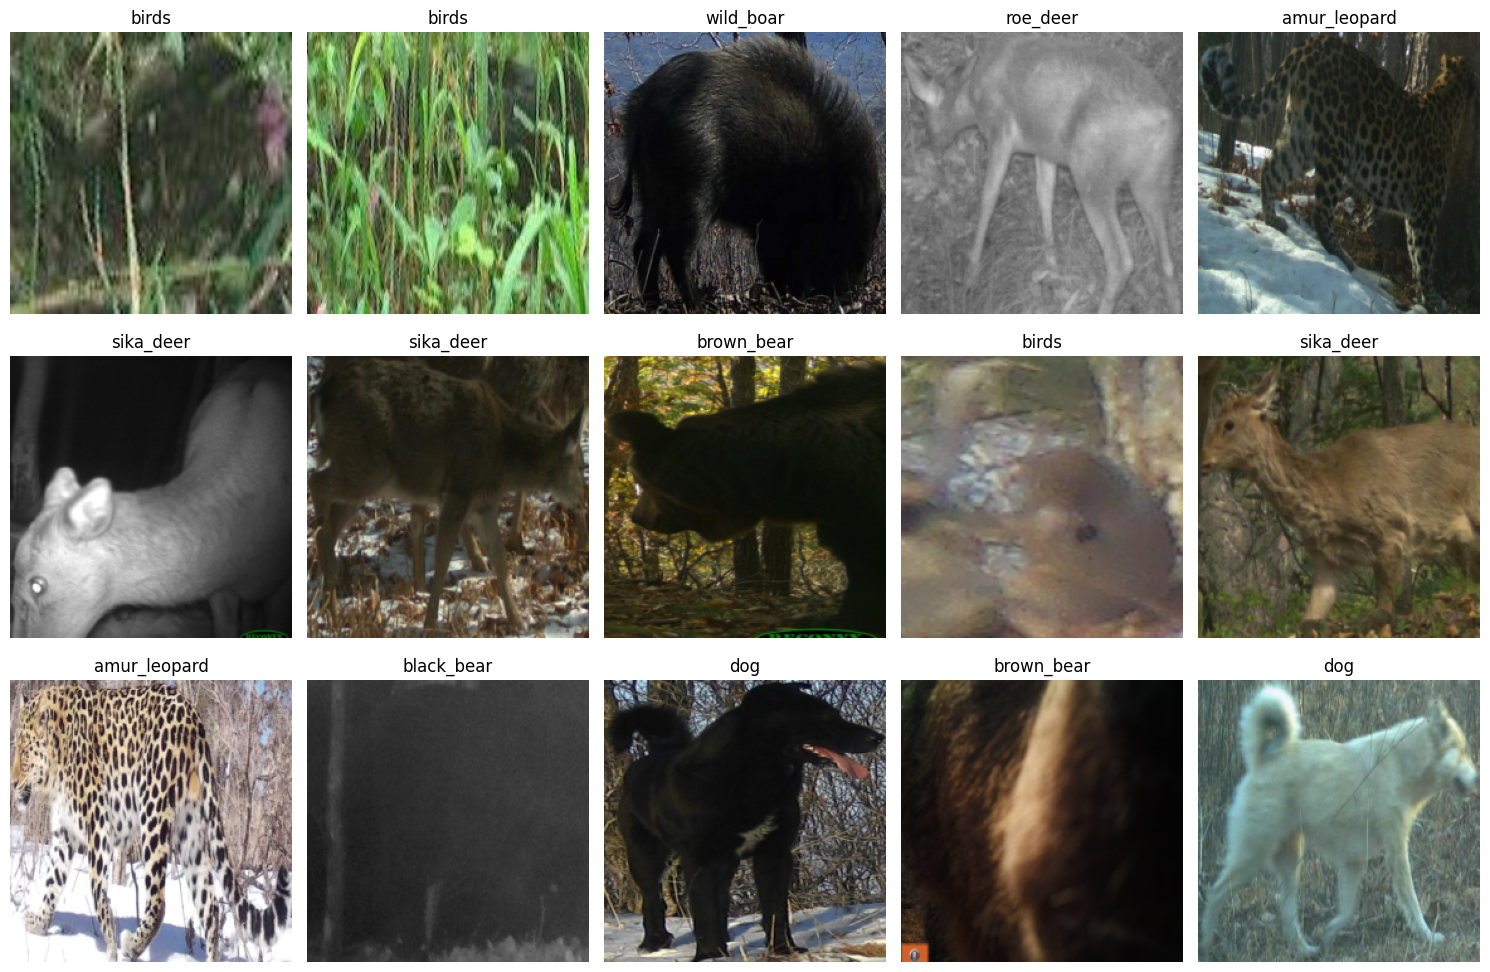

In [31]:
num_rows = 3
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= len(val_dataset):
            break
        sample = val_dataset[idx]
        axs[i, j].set_title(f"{dataset.get_class_name(sample['label'])}")
        axs[i, j].axis('off')
        # Bringing the image to (0, 255) space, reducing the batch dimension, converting float to int and converting Tensor to PIL Image
        image = transforms.ToPILImage()((((sample['image']+1)/2) * 255).squeeze().to(torch.uint8))
        axs[i, j].imshow(image)
plt.tight_layout()
plt.show()

In [34]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layer1 = nn.Sequential(
        # First Convolutional Layer
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )
    self.conv_layer2 = nn.Sequential(
        # Second Convolutional Layer
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_layer3 = nn.Sequential(
        # Third Convolutional Layer
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fully_connected = nn.Sequential(
        nn.Linear(128*14*14, 10),
        nn.ReLU()
    )
    self.Softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = torch.flatten(x, 1)
    logits = self.fully_connected(x)
    return logits

  def softmax(self, x):
    x = self.Softmax(x)
    return x

model = ConvNet()

In [38]:
model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
def loss_acc_calc(dataloader):
  with torch.no_grad():
    correct, total, loss = 0, 0, 0.0
    for i, sample in enumerate(dataloader, 0):
      images = sample['image']
      labels = sample['label']
      forwards = model.forward(images)
      logits = model.softmax(forwards)
      preds = torch.argmax(logits, dim=1)
      correct += torch.eq(preds, labels).sum().item()
      total += labels.size(0)
      loss_val = loss_fn(forwards, labels)
      loss += loss_val.item()
  return correct, total, loss

In [ ]:
wandb.watch(model)

In [ ]:
running_loss = 0.0
for epoch in range(model_config['epochs']):
  for i, sample in enumerate(train_dataloader, 0):
    # fetch data
    input = sample['image']
    label = sample['label']
    # zero the gradients before backprop
    optimizer.zero_grad()
    # forward pass
    logits = model.forward(input)
    loss = loss_fn(logits, label)
    # backprop
    loss.backward()
    optimizer.step()
    # loss computations and logging
    minibatch_loss = loss.item()
    running_loss += minibatch_loss
    # logging all the minibatch loss values
    wandb.log({"Minibatch Loss per Epoch": minibatch_loss})
    # logging after every 100 mini-batches
    if (i%100==0):
      # for every 100th mini-batch, computing training, val loss and accuracies, along with running loss logging
      running_loss /= 100.0
      # computing train loss, train accuracy, val loss, val accuracy
      train_correct, train_total, train_loss = loss_acc_calc(train_dataloader)
      val_correct, val_total, val_loss = loss_acc_calc(val_dataloader)
      # logging train loss, train acc, val loss, val acc and running loss
      train_acc = train_correct * 100.0 / train_total
      val_acc = val_correct * 100.0 / val_total
      wandb.log({"Training Accuracy": train_acc, "Validation Accuracy": val_acc, "Training Loss": train_loss, "Validation Loss": val_loss, "Running Loss": running_loss})
      running_loss = 0.0

In [ ]:
model.to_onxx()
wandb.save("Model.onxx")

In [ ]:
# Computing test loss, test acc and f-1 score
test_correct, test_total, test_loss = loss_acc_calc(test_dataloader)
test_acc = test_correct*100.0/test_total
print(f"Test Accuracy: {test_acc}%")
print(f"Test Loss: {test_loss}")
wandb.log({"Test Accuracy": test_acc, "Test Loss": test_loss})
# write code to compute test f1-score
# write code to compute and log test confusion matrix